In [ ]:
# https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51
# https://deeplearning.neuromatch.io/tutorials/W3D1_AttentionAndTransformers/student/W3D1_Tutorial1.html
# https://github.com/tonyduan/transformer-blocks/blob/master/src/blocks.py
# https://github.com/TranQuocTrinh/transformer


In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')

from IPython import display

from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

<Figure size 640x480 with 0 Axes>

In [4]:
def set_seed(seed = 1234):
    """_summary_
    Sets the seed of the entire notebook so results are the same every time we run.
    This is for reproducilibilty.

    Args:
        seed (int, optional): _description_. Defaults to 1234.
    """

    # Set the random seed manually for reproducibility.
    np.random.seed(seed)
    random.seed(seed)
    th.manual_seed(seed)
    th.cuda.manual_seed(seed)

    # When running on the CuDNN backend, two further options must be set
    th.backends.cudnn.deterministic = True


set_seed()

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(f"Avaliable device is {device}")


Avaliable device is cpu


#### Scaled Dot-Product Attention

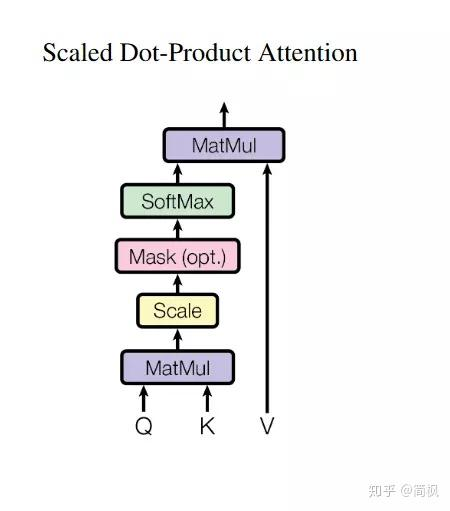

In [12]:
image_url = "./Figures/scaled_dot_product_attn.jpg"
display.Image(filename=image_url, height=400, width=300)


#### Scaled Dot Product Attention

In [11]:
def scaled_dot_product(q, k, v, mask=None):
    
    d_k = q.size()[-1]
    attn_logits = th.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)

    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)

    attention = F.softmax(attn_logits, dim=-1)
    values = th.matmul(attention, v)
    
    return values, attention

In [12]:
seq_len, d_k = 3, 2

q = th.randn(seq_len, d_k)
k = th.randn(seq_len, d_k)
v = th.randn(seq_len, d_k)

values, attention = scaled_dot_product(q, k, v)

print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Q
 tensor([[ 0.4501,  0.2709],
        [-0.8087, -0.0217],
        [-1.0413,  0.0702]])
K
 tensor([[ 0.5797, -0.0599],
        [ 0.1816, -0.6797],
        [-0.2567, -1.8189]])
V
 tensor([[0.2111, 0.3372],
        [0.6638, 1.0397],
        [1.8434, 0.6588]])
Values
 tensor([[0.7465, 0.6486],
        [1.0466, 0.6999],
        [1.0512, 0.7022]])
Attention
 tensor([[0.4293, 0.3359, 0.2349],
        [0.2548, 0.3230, 0.4223],
        [0.2502, 0.3253, 0.4245]])


#### Multi-Head Attention

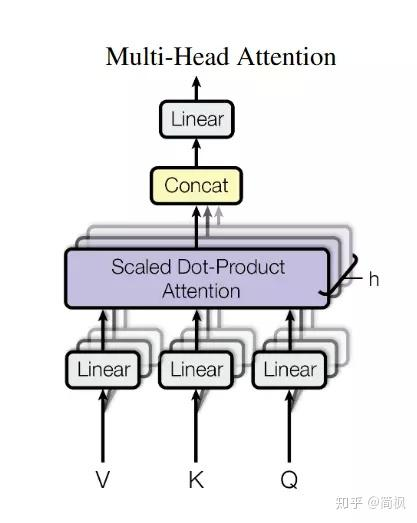

In [20]:
image_url = "./Figures/multihead_attn.jpg"
display.Image(filename=image_url, height=300, width=300)

In [13]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = th.nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = th.nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        th.nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        
        th.nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, _ = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention:
            return o, attention
        else:
            return o

#### Transformer Encoder Blocks

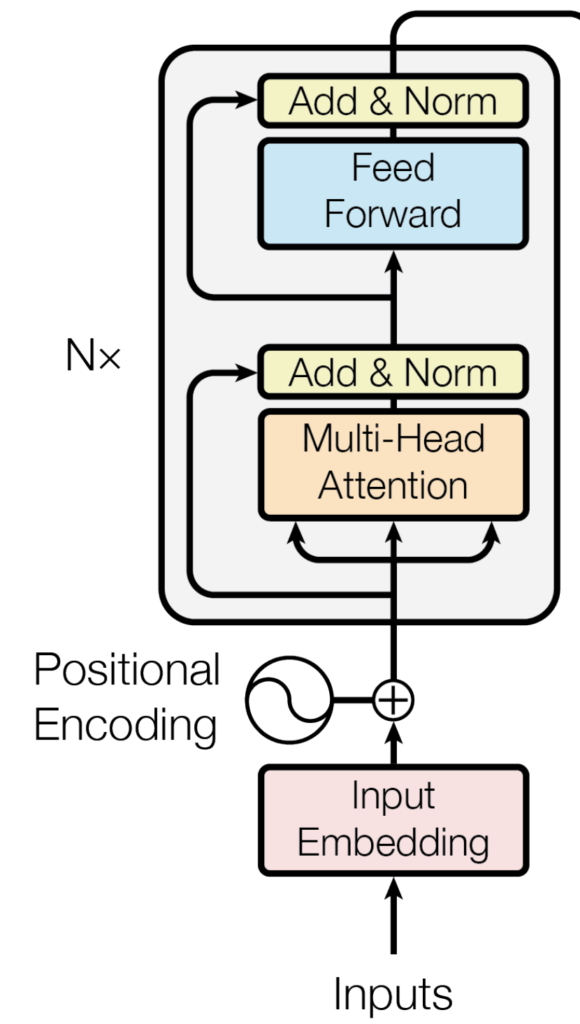

In [49]:
image_url = "./Figures/encoder_layer_class.jpg"
display.Image(filename=image_url, height=200, width=200)

##### Encoder Block

In [ ]:
class EncoderBlock(th.nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            th.nn.Linear(input_dim, dim_feedforward),
            th.nn.Dropout(dropout),
            th.nn.ReLU(inplace=True),
            th.nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm0 = th.nn.LayerNorm(input_dim)
        self.norm1 = th.nn.LayerNorm(input_dim)
        self.dropout = th.nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm0(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm1(x)

        return x

In [ ]:
class TransformerEncoder(th.nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = th.nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            _, attn_map = layer.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = layer(x)
        return attention_maps

##### Positional Encoding

In [25]:
class PositionalEncoding(th.nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = th.zeros(max_len, d_model)
        position = th.arange(0, max_len, dtype=th.float).unsqueeze(1)
        div_term = th.exp(th.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = th.sin(position * div_term)
        pe[:, 1::2] = th.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

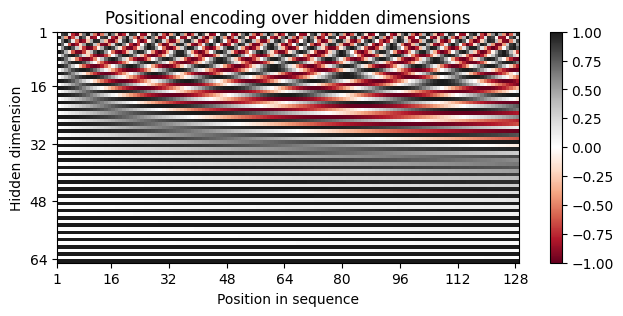

In [34]:
pe_block = PositionalEncoding(d_model=64, max_len=128)
pe = pe_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)

ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")

ax.set_xticks([1]+[i*16 for i in range(1,1+pe.shape[1]//16)])
ax.set_yticks([1]+[i*16 for i in range(1,1+pe.shape[0]//16)])
plt.show()

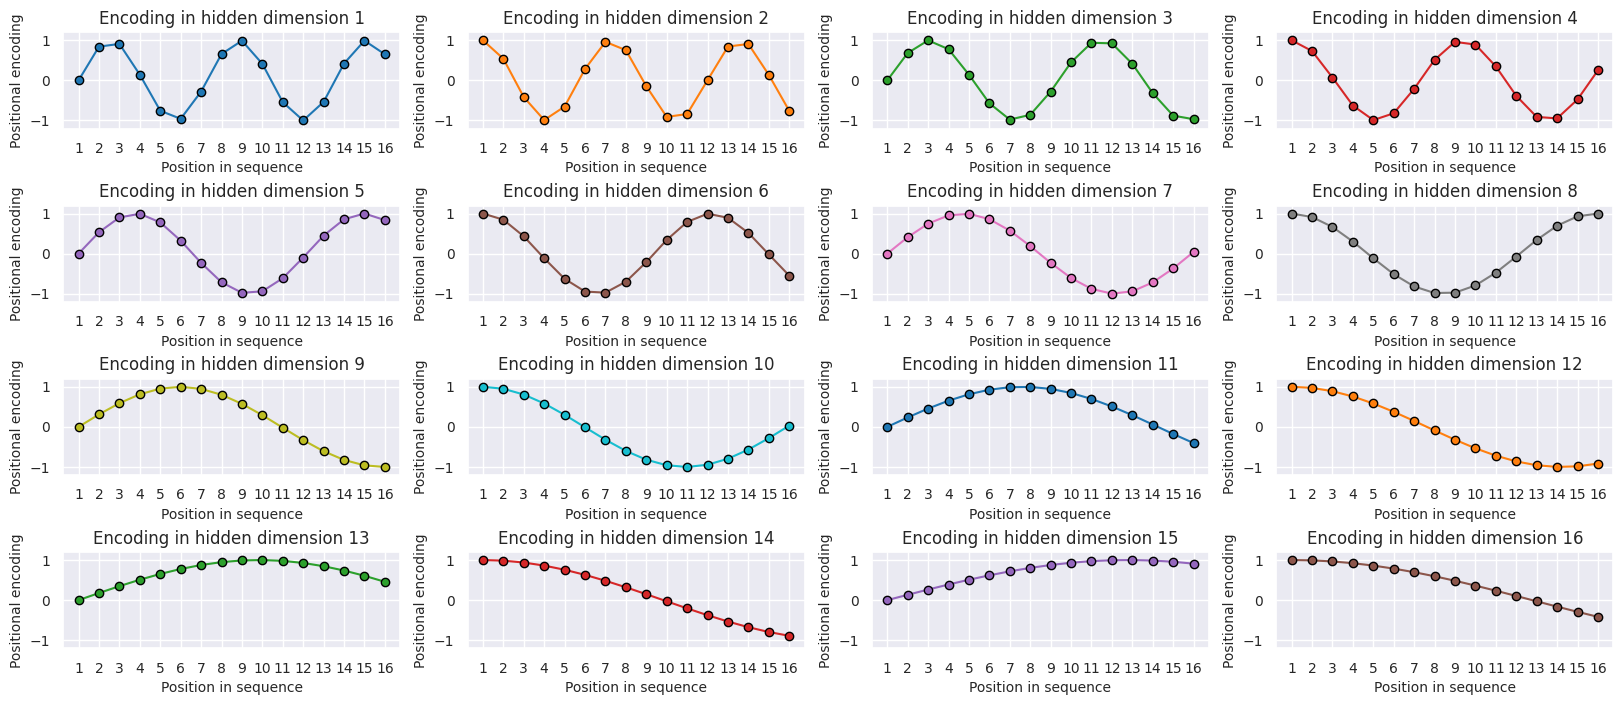

In [43]:
sns.set_theme()
num_points = 16

fig, ax = plt.subplots(4, 4, figsize=(20,8))

ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,num_points+1), pe[i,:num_points], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")

    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)

    ax[i].set_xticks(np.arange(1,num_points+1))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)

fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()